In [1]:
import os
#import csv
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from gimpformats.gimpXcfDocument import GimpDocument
#from skimage.metrics import structural_similarity as ssim
#from sklearn.metrics import mean_squared_error as mse

#from PIL import Image
#from torch.utils.data import DataLoader
#import torch.nn.functional as func

from datasets import SkullUSDataset
#from models import SimpleUNet
#from copy import deepcopy
from utils import load_xcf, makeDict
from metrics import hull, concave_hull, convex_hull

from descartes import PolygonPatch
import alphashape


In [2]:
%matplotlib inline 

In [71]:
def anatStructMask(set1, height, width, alpha=0.01):
    if len(set1) > 2:
        poly1 = hull(set1, alpha)

        minx1, miny1, maxx1, maxy1 = poly1.bounds

        if np.any(np.isnan(poly1.bounds)): 
            raise Exception("Problems computing Anatomical Structure Hull, hull crashed ")
        else:
            #maxx = int(max(maxx1, maxx2) * 1.2)
            #maxy = int(max(maxy1, maxy2) * 1.2)

            im1 = np.zeros([height, width, 1])

            points1 = list(zip(*poly1.exterior.coords.xy))
            points1 = [[int(x), int(y)] for x, y in points1]
            points1 = np.array(points1)

            #print(points1)

            #cv2.fillPoly(im1, pts=[points1], color=255)
            cv2.polylines(im1, pts=[points1], color=255, isClosed=True, thickness=5)

            mask = im1

    else:
        raise Exception("Problems computing Anatomical Structure Hull, not enough points ")

    return mask

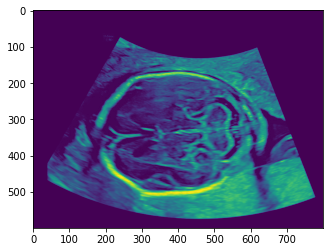

current layer Córtex
Layer Córtex has too few points 2
current layer calota
current layer talems
current layer cerebel
current layer cavum
current layer silvio
current layer astes anteriors
Layer astes anteriors has too few points 2
current layer linia mitja
Layer linia mitja has too few points 2


In [72]:

# Load image

image, data, labels, points = load_xcf("data/1.xcf")

dict1 = makeDict(labels,points)

height, width = image.shape

# compute alphashapes
#print(dict1)

plt.imshow(image)
plt.show()


# Compute the concave and convex hulls of a data set
aDict = dict1
# Retrieve all layers
for lay in aDict.keys():
    #for every layer, get its points
    aPointSet = aDict[lay]
    print("current layer "+str(lay))
    #if we don't have at least 3 points we cannot compute anything
    if len(aPointSet) > 2 :

        mask = anatStructMask(aPointSet, height, width)

        #cv2.imwrite(lay+"sam.jpg",mask)
                       
        
        
    else:
        print("Layer "+lay+" has too few points "+str(len(aPointSet)))





In [73]:
def layerMask(lay,aDict,height, width):
    aPointSet = aDict[lay]
    #if we don't have at least 3 points we cannot compute anything
    if len(aPointSet) > 2 :
        return anatStructMask(aPointSet, height, width)
    else:
        raise Exception("layerMask, too few points")



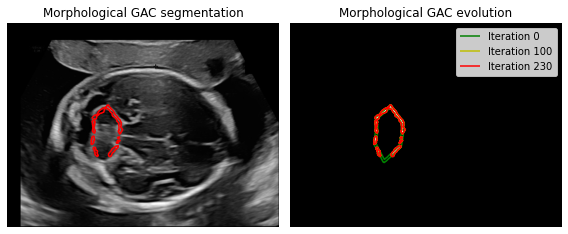

In [84]:
# source https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_morphsnakes.html

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)


def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store


# Load image

image, data, labels, points = load_xcf("data/4.xcf")

dict1 = makeDict(labels,points)

height, width = image.shape

lay = "cerebel"

mask = layerMask(lay,dict1,height, width)
cv2.imwrite("ou.jpg",mask)

# Morphological GAC
#image = img_as_float(data.coins())
gimage = inverse_gaussian_gradient(image)

# Initial level set
#init_ls = np.zeros(image.shape, dtype=np.int8)
#init_ls[10:-10, 10:-10] = 1
init_ls=np.squeeze(mask)

# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_geodesic_active_contour(gimage, iterations=230,
                                           init_level_set=init_ls,
                                           smoothing=1, balloon=-1,
                                           threshold=0.69,
                                           iter_callback=callback)

fig, axes = plt.subplots(1, 2, figsize=(8, 8))
ax = axes.flatten()


ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological GAC segmentation", fontsize=12)

ax[1].set_axis_off()
ax[1].imshow(ls, cmap="gray")
contour = ax[1].contour(evolution[0], [0.5], colors='g')
contour.collections[0].set_label("Iteration 0")
contour = ax[1].contour(evolution[100], [0.5], colors='y')
contour.collections[0].set_label("Iteration 100")
contour = ax[1].contour(evolution[-1], [0.5], colors='r')
contour.collections[0].set_label("Iteration 230")
ax[1].legend(loc="upper right")
title = "Morphological GAC evolution"
ax[1].set_title(title, fontsize=12)

fig.tight_layout()
plt.show()

/home/x/anaconda3/envs/fetal/lib/python3.6/site-packages/ipykernel_launcher.py:29: FutureWarning: The coordinates used by `active_contour` will change from xy coordinates (transposed from image dimensions) to rc coordinates in scikit-image 0.18. Set `coordinates='rc'` to silence this warning. `coordinates='xy'` will restore the old behavior until 0.18, but will stop working thereafter.


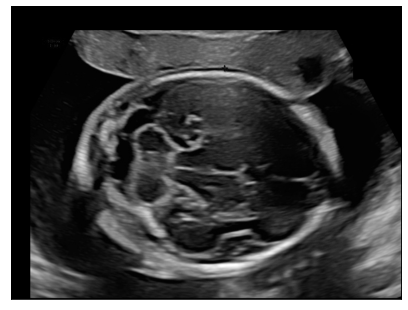

In [87]:
# not working properly


import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour


# Load image

image, data, labels, points = load_xcf("data/4.xcf")

dict1 = makeDict(labels,points)

height, width = image.shape

lay = "cerebel"

mask = layerMask(lay,dict1,height, width)


#img = rgb2gray(img)

img = image

init = np.squeeze(mask)

snake = active_contour(gaussian(img, 3, preserve_range=False),
                       init, alpha=0.015, beta=10, gamma=0.001)

fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(img, cmap=plt.cm.gray)
ax.plot(init[:, 1], init[:, 0], '--r', lw=3)
ax.plot(snake[:, 1], snake[:, 0], '-b', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img.shape[1], img.shape[0], 0])

plt.show()